In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
import ruptures as rpt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


/home/anthony/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/anthony/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
Xtr = pd.read_parquet(r'/data1/anthony/kaggle_CMI_sleep/train_series.parquet')
Ytr = pd.read_csv(r'/data1/anthony/kaggle_CMI_sleep/train_events.csv')
Xte = pd.read_parquet(r'/data1/anthony/kaggle_CMI_sleep/test_series.parquet')

In [4]:
IDtr = np.unique(Xtr.loc[:,'series_id'])
IDte = np.unique(Xte.loc[:,'series_id'])
TrValData = Xtr.groupby('series_id')
YtrGroups = Ytr.groupby('series_id')
teData = Xte.groupby('series_id')
trDataDict = {}
teDataDict = {}

# Iterate over groups and store them in the dictionary
for ID, data in TrValData:
#     print(ID)
    trDataDict[ID] = data
for ID, data in teData:
#     print(ID)
    teDataDict[ID] = data

In [5]:
exampleX = Xtr[Xtr['series_id']=='038441c925bb']
exampleY = Ytr[Ytr['series_id']=='038441c925bb'].dropna()

In [6]:
exampleY

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
5,038441c925bb,3,wakeup,44400.0,2018-08-17T05:10:00-0400
6,038441c925bb,4,onset,57240.0,2018-08-17T23:00:00-0400
7,038441c925bb,4,wakeup,62856.0,2018-08-18T06:48:00-0400
10,038441c925bb,6,onset,91296.0,2018-08-19T22:18:00-0400
11,038441c925bb,6,wakeup,97860.0,2018-08-20T07:25:00-0400


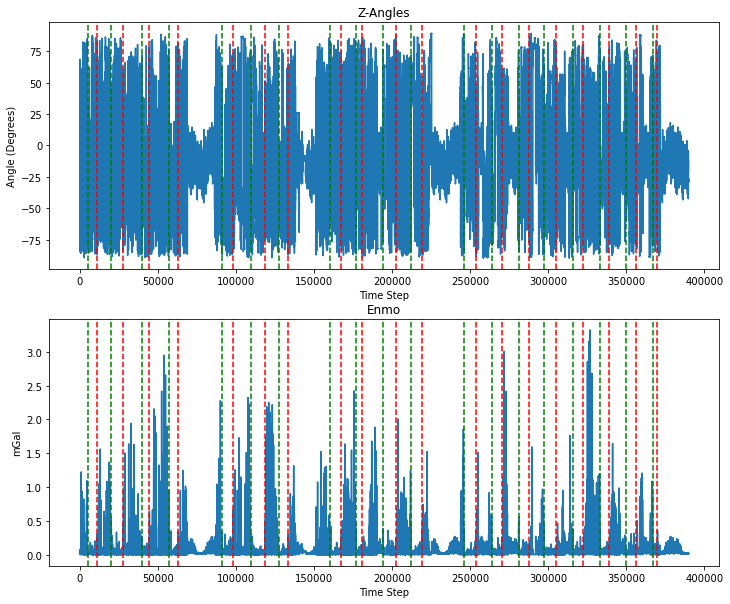

In [7]:
# np.array(exampleData['step'])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].plot(np.array(exampleX['step']),np.array(exampleX['anglez']))
ax[1].plot(np.array(exampleX['step']),np.array(exampleX['enmo']))


for onsetT in exampleY[exampleY['event']=='onset']['step']:
    ax[0].axvline(x=onsetT, color='g', linestyle='--')
    ax[1].axvline(x=onsetT, color='g', linestyle='--')
    
for wakeup in exampleY[exampleY['event']=='wakeup']['step']:
    ax[0].axvline(x=wakeup, color='r', linestyle='--')
    ax[1].axvline(x=wakeup, color='r', linestyle='--')
ax[0].set_title('Z-Angles')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Angle (Degrees)')

ax[1].set_title('Enmo')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('mGal')
    
plt.show()

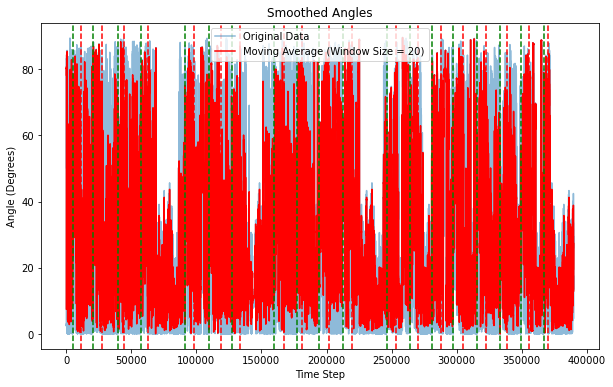

In [8]:
anglezDataEx = np.abs(np.array(exampleX['anglez']))
enmoDataEx = np.abs(np.array(exampleX['enmo']))
window_size = 20
smoothed_data = np.convolve(anglezDataEx, np.ones(window_size)/window_size, mode='valid')

# Plot original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(np.array(exampleX['step']),anglezDataEx, label='Original Data', alpha=0.5)
plt.plot(np.array(exampleX['step'])[:len(smoothed_data)], smoothed_data, label=f'Moving Average (Window Size = {window_size})', color='red')
plt.legend()
plt.title('Smoothed Angles')
plt.xlabel('Time Step')
plt.ylabel('Angle (Degrees)')


for onsetT in exampleY[exampleY['event']=='onset']['step']:
    plt.axvline(x=onsetT, color='g', linestyle='--')
    
for wakeup in exampleY[exampleY['event']=='wakeup']['step']:
    plt.axvline(x=wakeup, color='r', linestyle='--')
plt.show()

### Maxpass

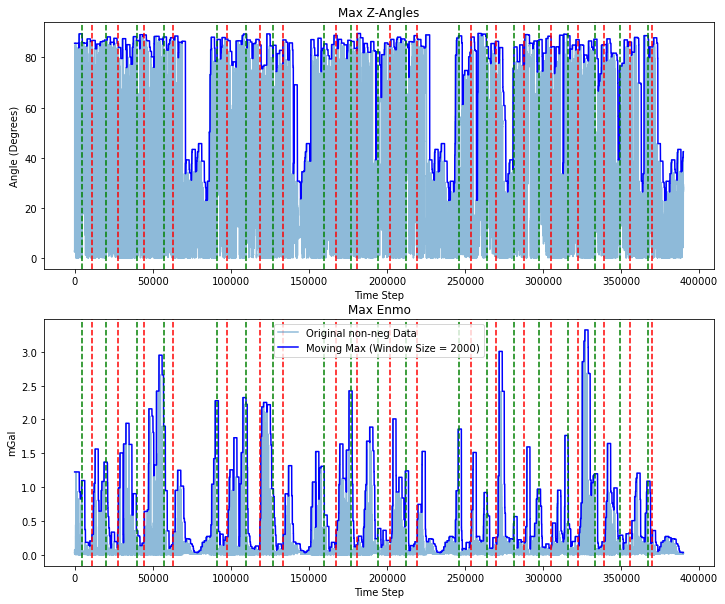

In [9]:
maxAnglez = np.zeros(len(anglezDataEx))
maxEnmo = np.zeros(len(enmoDataEx))
start = 2000
maxAnglez[0:start]=np.max(anglezDataEx[0:start])
maxEnmo[0:start]=np.max(enmoDataEx[0:start])
for i in range(start, len(anglezDataEx)):
#     print(i, anglezDataEx[i-start:i])
    maxAnglez[i] = np.max(anglezDataEx[i-start:i])
    maxEnmo[i] = np.max(enmoDataEx[i-start:i])
#     maxAnglez[i-start:i] = np.max(np.max(maxAnglez[i-start:i]),np.max(anglezDataEx[i-start:i]))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].plot(np.array(exampleX['step']),anglezDataEx, label='Original non-neg Data', alpha=0.5)
ax[0].plot(np.array(exampleX['step']), maxAnglez, label=f'Moving Max (Window Size = {start})', color='b')

ax[1].plot(np.array(exampleX['step']),enmoDataEx, label='Original non-neg Data', alpha=0.5)
ax[1].plot(np.array(exampleX['step']), maxEnmo, label=f'Moving Max (Window Size = {start})', color='b')

for onsetT in exampleY[exampleY['event']=='onset']['step']:
    ax[0].axvline(x=onsetT, color='g', linestyle='--')
    ax[1].axvline(x=onsetT, color='g', linestyle='--')
    
for wakeup in exampleY[exampleY['event']=='wakeup']['step']:
    ax[0].axvline(x=wakeup, color='r', linestyle='--')
    ax[1].axvline(x=wakeup, color='r', linestyle='--')

ax[0].set_title('Max Z-Angles')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Angle (Degrees)')

ax[1].set_title('Max Enmo')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('mGal')

plt.legend()
plt.show()

### Smoothing maxpass

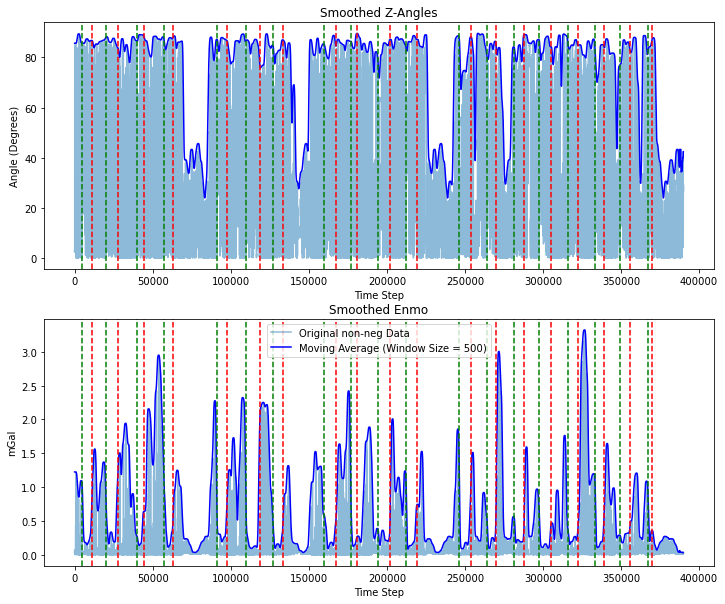

In [10]:
numRounds = 5
window_size = 500
smoothedAnglez = maxAnglez
smoothingA = maxAnglez
smoothedEnmo = maxEnmo
smoothingE = maxEnmo
for rounds in range(numRounds):
    smoothingA = np.convolve(smoothingA, np.ones(window_size)/window_size, mode='valid')
    smoothingE = np.convolve(smoothingE, np.ones(window_size)/window_size, mode='valid')

smoothedAnglez[0:len(smoothingA)] = smoothingA
smoothedEnmo[0:len(smoothingE)] = smoothingE
# print(len(smoothedAnglez))
# print(len(maxAnglez))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].plot(np.array(exampleX['step']),anglezDataEx, label='Original non-neg Data', alpha=0.5)
ax[0].plot(np.array(exampleX['step'])[:len(smoothedAnglez)], smoothedAnglez, label=f'Moving Average (Window Size = {window_size})', color='b')

ax[1].plot(np.array(exampleX['step']),enmoDataEx, label='Original non-neg Data', alpha=0.5)
ax[1].plot(np.array(exampleX['step'])[:len(smoothedEnmo)], smoothedEnmo, label=f'Moving Average (Window Size = {window_size})', color='b')

for onsetT in exampleY[exampleY['event']=='onset']['step']:
    ax[0].axvline(x=onsetT, color='g', linestyle='--')
    ax[1].axvline(x=onsetT, color='g', linestyle='--')
    
for wakeup in exampleY[exampleY['event']=='wakeup']['step']:
    ax[0].axvline(x=wakeup, color='r', linestyle='--')
    ax[1].axvline(x=wakeup, color='r', linestyle='--')

ax[0].set_title('Smoothed Z-Angles')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Angle (Degrees)')

ax[1].set_title('Smoothed Enmo')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('mGal')

plt.legend()
plt.show()

### Need to downsample for bayesian changepoint detection

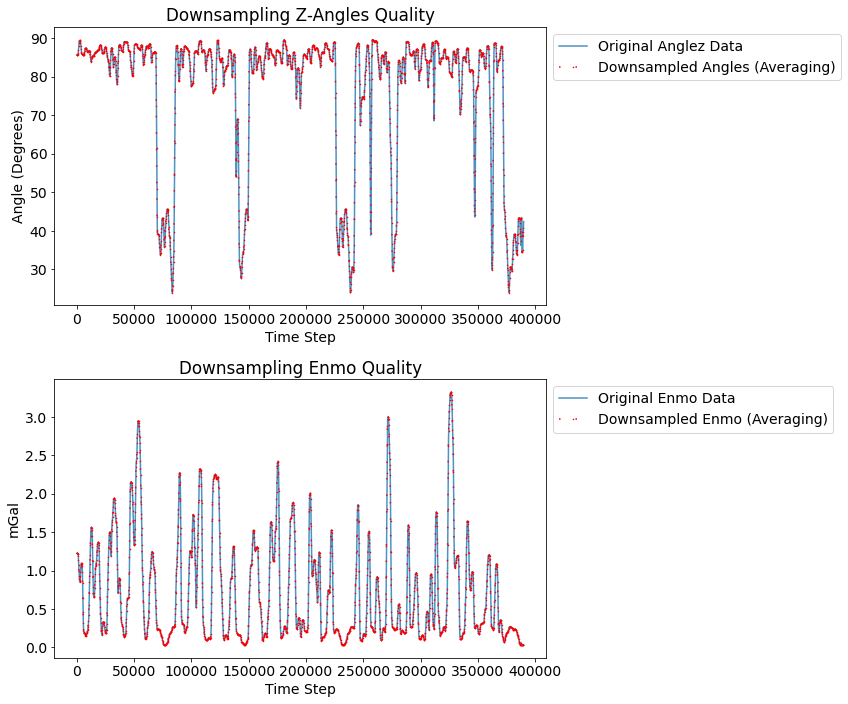

In [105]:
downsampling_factor = 200

# Reshape the data into a 2D array
downsampledAnglez = np.mean(smoothedAnglez[:len(smoothedAnglez)//downsampling_factor * downsampling_factor].reshape(-1, downsampling_factor), axis=1)
downsampledEnmo = np.mean(smoothedEnmo[:len(smoothedEnmo)//downsampling_factor * downsampling_factor].reshape(-1, downsampling_factor), axis=1)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax[0].plot(smoothedAnglez, label='Original Anglez Data', alpha=0.8)
ax[0].plot(np.arange(0, len(smoothedAnglez), downsampling_factor)[:-1], downsampledAnglez, 'r*', markersize=1, linestyle=(0, (1, 10)), label='Downsampled Angles (Averaging)')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
ax[0].set_title('Downsampling Z-Angles Quality')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Angle (Degrees)')

ax[1].plot(smoothedEnmo, label='Original Enmo Data', alpha=0.8)
ax[1].plot(np.arange(0, len(smoothedEnmo), downsampling_factor)[:-1], downsampledEnmo, 'r*', markersize=1, linestyle=(0, (1, 10)), label='Downsampled Enmo (Averaging)')
ax[1].set_title('Downsampling Enmo Quality')
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('mGal')

ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

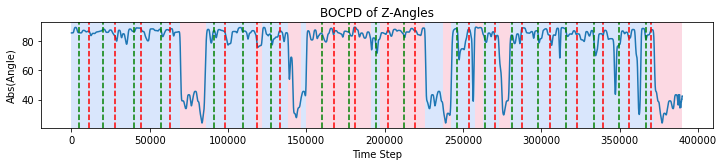

In [12]:
# Perform change point detection using BOCPD (Bayesian Online Change Point Detection) on Anglez
signal = downsampledAnglez
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=20)
#multiple result back up to fit graph
bocpdAnglez = np.array(result)*downsampling_factor
rpt.display(smoothedAnglez, bocpdAnglez)
for onsetT in exampleY[exampleY['event']=='onset']['step']:
    plt.axvline(x=onsetT, color='g', linestyle='--')
    
for wakeup in exampleY[exampleY['event']=='wakeup']['step']:
    plt.axvline(x=wakeup, color='r', linestyle='--')

plt.title('BOCPD of Z-Angles')
plt.xlabel('Time Step')
plt.ylabel('Abs(Angle)')
plt.show()

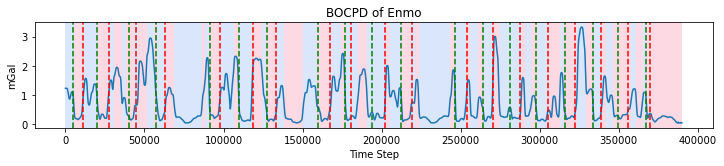

In [13]:
# Perform change point detection using BOCPD (Bayesian Online Change Point Detection) on Enmo
signal = downsampledEnmo
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)
#multiple result back up to fit graph
bocpdEnmo = np.array(result)*downsampling_factor
rpt.display(smoothedEnmo, bocpdEnmo)
for onsetT in exampleY[exampleY['event']=='onset']['step']:
    plt.axvline(x=onsetT, color='g', linestyle='--')
    
for wakeup in exampleY[exampleY['event']=='wakeup']['step']:
    plt.axvline(x=wakeup, color='r', linestyle='--')

plt.title('BOCPD of Enmo')
plt.xlabel('Time Step')
plt.ylabel('mGal')
plt.show()

In [14]:
# look at PCA
exampleX.drop(columns=['series_id','step','timestamp'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(exampleX.drop(columns=['series_id','step','timestamp']))

pca = PCA()
principal_components = pca.fit_transform(scaled_data)
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_ratio_
print(eigenvalues)
# print(principal_components[:,0].shape)
# plt.scatter(principal_components[:,0],principal_components[:,1])
# plt.scatter(scaled_data[:,0],scaled_data[:,1])
plt.show()
#no real correlation, and anglez looks useless --> not going to use it

[0.51246572 0.48753428]


/home/anthony/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/home/anthony/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


In [15]:
downsampledY = exampleY.drop(columns=['timestamp','series_id','night'])
downsampledY.loc[:,'step'] = downsampledY['step']//downsampling_factor
downsampledY = downsampledY.values
bocpdEnmoDown = bocpdEnmo//downsampling_factor
# print(downsampledY[:,1])
# len(downsampledEnmo)
downTimeY = np.full(len(downsampledEnmo), 0) #contains all downsampled timesteps with events/no events
nearBOCPDEnmo = np.full(len(downsampledEnmo), 0)
for i,(event,step) in enumerate(downsampledY):
    if event=='onset':
        downTimeY[int(step)] = 1
    elif event=='wakeup':
        downTimeY[int(step)] = 2

for i, step in enumerate(bocpdEnmoDown):
    nearRange = [np.maximum(0, step-100//downsampling_factor), np.minimum(len(downsampledEnmo), step+100//downsampling_factor)]
    nearBOCPDEnmo[nearRange[0]:nearRange[1]]==1

scaledDownSampledEnmo = StandardScaler().fit_transform(downsampledEnmo.reshape(-1, 1))
oneHotDownY = np.eye(3)[downTimeY]
downX = pd.DataFrame([nearBOCPDEnmo, scaledDownSampledEnmo]).T


## Dataprep func

In [16]:
def toTrainFormat(dataX, dataY, maxLen, maxStart = 2000, smoothRounds = 5, smoothWindow = 500, downFac = 100):
    #maxpass
    enmoDataEx = np.abs(np.array(dataX['enmo']))
    maxEnmo = np.zeros(len(enmoDataEx))
    start = maxStart
    maxEnmo[0:start]=np.max(enmoDataEx[0:start])
    for i in range(start, len(enmoDataEx)):
        maxEnmo[i] = np.max(enmoDataEx[i-start:i])
    
    numRounds = smoothRounds
    window_size = smoothWindow
    smoothing = maxEnmo
    for rounds in range(numRounds):
        smoothing = np.convolve(smoothing, np.ones(window_size)/window_size, mode='valid')
    smoothedEnmo = maxEnmo
    smoothedEnmo[0:len(smoothing)] = smoothing
    downsampling_factor = downFac
#     print('smoothedEnmo shape: ',len(smoothedEnmo))
    downsampledEnmo = np.mean(smoothedEnmo[:len(smoothedEnmo)//downsampling_factor * downsampling_factor].reshape(-1, downsampling_factor), axis=1)
#     print('downsample shape: ',len(downsampledEnmo))
    signal = downsampledEnmo
    algo = rpt.Pelt(model="rbf").fit(signal)
    result = algo.predict(pen=10)
    bocpdEnmo = np.array(result)*downsampling_factor
    
    dataY = dataY.dropna()
    downsampledY = dataY.drop(columns=['timestamp','series_id','night'])
    downsampledY.loc[:,'step'] = downsampledY['step']//downsampling_factor
    downsampledY = downsampledY.values
    bocpdEnmoDown = bocpdEnmo//downsampling_factor #since we divided #steps by downFac, we need to reflect that
    downTimeY = np.full(len(downsampledEnmo), 0) #contains all downsampled timesteps with events/no events
    nearBOCPDEnmo = np.full(len(downsampledEnmo), 0)
    for i,(event,step) in enumerate(downsampledY):
        if event=='onset':
            downTimeY[np.minimum(int(step),len(downTimeY)-1)] = 1
        elif event=='wakeup':
            downTimeY[np.minimum(int(step),len(downTimeY)-1)] = 2

    for i, step in enumerate(bocpdEnmoDown):
        nearRange = [np.maximum(0, step-100//downsampling_factor), np.minimum(len(downsampledEnmo), step+100//downsampling_factor)]
        nearBOCPDEnmo[nearRange[0]:nearRange[1]]==1

    scaledDownSampledEnmo = StandardScaler().fit_transform(downsampledEnmo.reshape(-1, 1))
    oneHotDownY = np.eye(3)[downTimeY]
    downX = pd.DataFrame([nearBOCPDEnmo, scaledDownSampledEnmo]).T
    #TODO: add padding
    outputMaxLen = maxLen//downFac #output max length is smaller for model
    origLen = downX.values.shape[0] #need original length to fun in LSTM
    paddedDownX = np.array([np.pad(seq, (0, outputMaxLen - len(seq)), 'constant') for seq in downX.values.T])
    paddedOneHotDownY = np.array([np.pad(seq, (0, outputMaxLen - len(seq)), 'constant') for seq in oneHotDownY.T])
    
    return paddedDownX.T, paddedOneHotDownY.T, origLen


In [18]:
def visualize(dataX, maxStart = 2000, smoothRounds = 5, smoothWindow = 500, downFac = 100):
    #maxpass
    enmoDataEx = np.abs(np.array(dataX['enmo']))
    maxEnmo = np.zeros(len(enmoDataEx))
    angleDataEx = np.abs(np.array(dataX['anglez']))
    maxAngle = np.zeros(len(angleDataEx))
    start = maxStart
    maxEnmo[0:start]=np.max(enmoDataEx[0:start])
    maxAngle[0:start]=np.max(angleDataEx[0:start])
    for i in range(start, len(enmoDataEx)):
        maxEnmo[i] = np.max(enmoDataEx[i-start:i])
        maxAngle[i] = np.max(angleDataEx[i-start:i])
    
    numRounds = smoothRounds
    window_size = smoothWindow
    smoothing = maxEnmo
    smoothingA = maxAngle
    for rounds in range(numRounds):
        smoothing = np.convolve(smoothing, np.ones(window_size)/window_size, mode='valid')
        smoothingA = np.convolve(smoothingA, np.ones(window_size)/window_size, mode='valid')
    smoothedEnmo = maxEnmo
    smoothedAngle = maxAngle
    smoothedEnmo[0:len(smoothing)] = smoothing
    smoothedAngle[0:len(smoothing)] = smoothingA
    downsampling_factor = downFac
#     print('smoothedEnmo shape: ',len(smoothedEnmo))
    downsampledEnmo = np.mean(smoothedEnmo[:len(smoothedEnmo)//downsampling_factor * downsampling_factor].reshape(-1, downsampling_factor), axis=1)
    downsampledAngle = np.mean(smoothedAngle[:len(smoothedEnmo)//downsampling_factor * downsampling_factor].reshape(-1, downsampling_factor), axis=1)
    #     print('downsample shape: ',len(downsampledEnmo))
    signal = downsampledEnmo
    algo = rpt.Pelt(model="rbf").fit(signal)
    result = algo.predict(pen=5)
    bocpdEnmo = np.array(result)*downsampling_factor
    
    signal = downsampledAngle
    algo = rpt.Pelt(model="rbf").fit(signal)
    result = algo.predict(pen=5)
    bocpdAngle = np.array(result)*downsampling_factor
    return bocpdEnmo, downsampledEnmo, bocpdAngle, downsampledAngle


### Gather all Data for Model Training/Val

In [19]:
np.random.seed(42)
valIDs = np.random.choice(IDtr, size=int(0.2 * len(np.unique(IDtr))), replace=False)
trIDs = IDtr[[ID not in valIDs for ID in IDtr]]

maxLen = 0
for key in trDataDict.keys():
    maxLen = np.maximum(trDataDict[key].shape[0], maxLen)
print(maxLen)

trData = {}
valData = {}
trValY = {}

for ID, data in TrValData: #first do train-val split
    if ID in trIDs:
        trData[ID] = data
    elif ID in valIDs:
        valData[ID] = data
    else:
        print('something went wrong')
for ID, data in YtrGroups:
    trValY[ID] = data

1433880


In [20]:
# trValY['0a96f4993bd7']
# trData['0a96f4993bd7']
len(trValY.keys())

277

In [21]:
#process the data
downFactor=200
counter = 0
totalNumFiles = len(trValY.keys())
trPadded = []
valPadded = []
for ID in trData.keys():
    X, Y, origLen = toTrainFormat(trData[ID], trValY[ID], maxLen, maxStart = 2000, 
                                  smoothRounds = 5, smoothWindow = 500, downFac = downFactor)
    trPadded.append([X, Y, origLen])
    counter = counter + 1
    print(str(np.round(counter/totalNumFiles*100,2))+str(r'%'))

for ID in valData.keys():
    X, Y, origLen = toTrainFormat(valData[ID], trValY[ID], maxLen, maxStart = 2000, 
                                  smoothRounds = 5, smoothWindow = 500, downFac = downFactor)
    valPadded.append([X, Y, origLen])
    counter = counter + 1
    print(str(np.round(counter/totalNumFiles*100,2))+str(r'%'))
    #TODO: add padding to processing definition
    
# for ID, data in valPadded:
    
#TODO: now we actually add the padding after processing the data

0.36%
0.72%
1.08%
1.44%
1.81%
2.17%
2.53%
2.89%
3.25%
3.61%
3.97%
4.33%
4.69%
5.05%
5.42%
5.78%
6.14%
6.5%
6.86%
7.22%
7.58%
7.94%
8.3%
8.66%
9.03%
9.39%
9.75%
10.11%
10.47%
10.83%
11.19%
11.55%
11.91%
12.27%
12.64%
13.0%
13.36%
13.72%
14.08%
14.44%
14.8%
15.16%
15.52%
15.88%
16.25%
16.61%
16.97%
17.33%
17.69%
18.05%
18.41%
18.77%
19.13%
19.49%
19.86%
20.22%
20.58%
20.94%
21.3%
21.66%
22.02%
22.38%
22.74%
23.1%
23.47%
23.83%
24.19%
24.55%
24.91%
25.27%
25.63%
25.99%
26.35%
26.71%
27.08%
27.44%
27.8%
28.16%
28.52%
28.88%
29.24%
29.6%
29.96%
30.32%
30.69%
31.05%
31.41%
31.77%
32.13%
32.49%
32.85%
33.21%
33.57%
33.94%
34.3%
34.66%
35.02%
35.38%
35.74%
36.1%
36.46%
36.82%
37.18%
37.55%
37.91%
38.27%
38.63%
38.99%
39.35%
39.71%
40.07%
40.43%
40.79%
41.16%
41.52%
41.88%
42.24%
42.6%
42.96%
43.32%
43.68%
44.04%
44.4%
44.77%
45.13%
45.49%
45.85%
46.21%
46.57%
46.93%
47.29%
47.65%
48.01%
48.38%
48.74%
49.1%
49.46%
49.82%
50.18%
50.54%
50.9%
51.26%
51.62%
51.99%
52.35%
52.71%
53.07%
53.43%
53.79

In [22]:
X_train = []
Y_train = []
train_lengths = []
for i in range(len(trPadded)):
    X_train.append(trPadded[i][0])
    Y_train.append(trPadded[i][1])
    train_lengths.append(trPadded[i][2])
    
X_val = []
Y_val = []
val_lengths = []
for i in range(len(valPadded)):
    X_val.append(valPadded[i][0])
    Y_val.append(valPadded[i][1])
    val_lengths.append(valPadded[i][2])

In [23]:
Y_train_intlabels = np.argmax(Y_train, axis=2)
Y_val_intlabels = np.argmax(Y_val, axis=2)

## Create weights, binary classification Y data, split tr and val sets, add padding

In [24]:
downFactor=200
totalNumFiles = len(trValY.keys())
trBinaryYPadded = []
valBinaryYPadded = []
binarySleepCounts = np.array([0,0]) #for [awake steps, asleep steps]
eventCounts = np.array([0,0,0]) #for [no event steps, onset steps, wakeup steps]
for i, key in enumerate(trValY.keys()):
    stepTot = trDataDict[key].shape[0]//downFactor
    binarySleep = np.zeros(stepTot)
    data = trValY[key].dropna()
    data = data.reset_index(drop=True)
    nights = np.unique(data['night'])
    binarySleepCounts[0] = binarySleepCounts[0] + stepTot #first add all steps, then subtract sleeping steps
    eventCounts[0] = eventCounts[0] + stepTot #same idea as above
    for j, night in enumerate(nights):
#         try: #downscale onset and wakeup steps
        hasOnset = len(data.loc[(data['night'] == night) & (data['event'] == 'onset'), 'step'])>0
        hasWakeup = len(data.loc[(data['night'] == night) & (data['event'] == 'wakeup'), 'step'])>0
        if hasOnset and hasWakeup:
            onsetStep = int(data.loc[(data['night'] == night) & (data['event'] == 'onset'), 'step'].iloc[0]//downFactor)
            wakeupStep = int(data.loc[(data['night'] == night) & (data['event'] == 'wakeup'), 'step'].iloc[0]//downFactor)
    #             print(np.minimum(wakeupStep, stepTot)-onsetStep)
    #             print(wakeupStep > onsetStep)
            if wakeupStep > onsetStep:
    #                 print('inside')
#                 print(len(binarySleep))
#                 print(onsetStep, np.minimum(wakeupStep, stepTot))
                binarySleep[onsetStep:np.minimum(wakeupStep, stepTot)] = 1
                binarySleepCounts[0] = binarySleepCounts[0] - (np.minimum(wakeupStep, stepTot)-onsetStep)
                binarySleepCounts[1] = binarySleepCounts[1] + np.minimum(wakeupStep, stepTot)-onsetStep
                eventCounts = eventCounts + np.array([-2,1,1])
            else:
                print('oops')
                continue
    #         except: #data with just 'onset' or 'wakeup' don't define a sleep period --> excluded
    # #             print(data[data['night'] == night])
    #             print('error')
    #             continue
        else:
            continue
    binarySleepPad = np.array(np.pad(binarySleep, (0, maxLen//downFactor - len(binarySleep)), 'constant'))
    if key in trData.keys():
        trBinaryYPadded.append(binarySleepPad)
    elif key in valData.keys():
        valBinaryYPadded.append(binarySleepPad)
    else:
        print('something went wrong')
    print(str(np.round(i/totalNumFiles*100,2))+str(r'%'))

# trValYBinary = {}

# for i, key in enumerate(trValY.keys()):
#     stepTot = trDataDict[key].shape[0]
#     binarySleep = np.zeros(stepTot)
#     data = trValY[key].dropna()
#     data = data.reset_index(drop=True)
#     nights = np.unique(data['night'])
#     binarySleepCounts[0] = binarySleepCounts[0] + stepTot #first add all steps, then subtract sleeping steps
#     eventCounts[0] = eventCounts[0] + stepTot #same idea as above
# #     print(data)
#     for i, night in enumerate(nights):
#         try:
#             onsetStep = int(data.loc[(data['night'] == night) & (data['event'] == 'onset'), 'step'].iloc[0])
#             wakeupStep = int(data.loc[(data['night'] == night) & (data['event'] == 'wakeup'), 'step'].iloc[0])
#             binarySleep[onsetStep:wakeupStep] = 1
#             binarySleepCounts[0] = binarySleepCounts[0] - (wakeupStep-onsetStep)
#             binarySleepCounts[1] = binarySleepCounts[1] + wakeupStep-onsetStep
#             eventCounts = eventCounts + np.array([-2,1,1])
#         except: #data with just 'onset' or 'wakeup' don't define a sleep period --> excluded
# #             print(data[data['night'] == night])
#             continue
#     trValYBinary[key] = binarySleep
    
binarySleepWeights = np.array((np.sum(binarySleepCounts))/binarySleepCounts).astype(float)
binarySleepWeights = binarySleepWeights/(np.sum(binarySleepWeights))
eventWeights = np.array((np.sum(eventCounts))/eventCounts).astype(float)
eventWeights = eventWeights/(np.sum(eventWeights))


0.0%
0.36%
0.72%
1.08%
1.44%
1.81%
2.17%
2.53%
2.89%
3.25%
3.61%
3.97%
4.33%
4.69%
5.05%
5.42%
5.78%
6.14%
6.5%
6.86%
7.22%
7.58%
7.94%
8.3%
8.66%
9.03%
9.39%
9.75%
10.11%
10.47%
10.83%
11.19%
11.55%
11.91%
12.27%
12.64%
13.0%
13.36%
13.72%
14.08%
14.44%
14.8%
15.16%
15.52%
15.88%
16.25%
16.61%
16.97%
17.33%
17.69%
18.05%
18.41%
18.77%
19.13%
19.49%
19.86%
20.22%
20.58%
20.94%
21.3%
21.66%
22.02%
22.38%
22.74%
23.1%
23.47%
23.83%
24.19%
24.55%
24.91%
25.27%
25.63%
25.99%
26.35%
26.71%
27.08%
27.44%
27.8%
28.16%
28.52%
28.88%
29.24%
29.6%
29.96%
30.32%
30.69%
31.05%
31.41%
31.77%
32.13%
32.49%
32.85%
33.21%
33.57%
33.94%
34.3%
34.66%
35.02%
35.38%
35.74%
36.1%
36.46%
36.82%
37.18%
37.55%
37.91%
38.27%
38.63%
38.99%
39.35%
39.71%
40.07%
40.43%
40.79%
41.16%
41.52%
41.88%
42.24%
42.6%
42.96%
43.32%
43.68%
44.04%
44.4%
44.77%
45.13%
45.49%
45.85%
46.21%
46.57%
46.93%
47.29%
47.65%
48.01%
48.38%
48.74%
49.1%
49.46%
49.82%
50.18%
50.54%
50.9%
51.26%
51.62%
51.99%
52.35%
52.71%
53.07%
53.43%


In [25]:
print(eventWeights) #way too skewed
print(binarySleepWeights) #ok
print(np.array(trBinaryYPadded).shape) #checking size
print(np.array(valBinaryYPadded).shape) #checking size

[0.00378701 0.49810649 0.49810649]
[0.23340786 0.76659214]
(222, 7169)
(55, 7169)


## Now test in binary sleep states 

In [44]:
# Convert to PyTorch tensors
torch.manual_seed(42)

X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

y_train_tensor = torch.FloatTensor(trBinaryYPadded)
y_val_tensor = torch.FloatTensor(valBinaryYPadded)

train_lengths_tensor = torch.FloatTensor(train_lengths)
val_lengths_tensor = torch.FloatTensor(val_lengths)

class_weights = torch.tensor(binarySleepWeights[1]/binarySleepWeights[0])
tr_class_weights = torch.tensor(np.tile(binarySleepWeights, (y_train_tensor.shape[0],1)))
binTrainLosses = []
binTrainAcc = []
binTrainWtAcc = []

print(X_train_tensor.shape)
# print(torch.argmax(y_train_tensor, dim=1).long().shape)
print(y_train_tensor.shape)
# # Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x, lengths):
        # Pack padded sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        # LSTM layer
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        out_packed, _ = self.lstm(x_packed, (h0, c0))
        # Unpack padded sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        # Fully connected layer
        out = self.fc(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = 2 #X_train_tensor.shape[1]
print('input size: ',input_size)
hidden_size = 128
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
criterion = nn.functional.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, train_lengths_tensor, tr_class_weights)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Training loop
num_epochs = 30
total_step = len(train_loader)
f1sAll = []
valAccAll = []
valWtAccAll = []
for epoch in range(num_epochs):
    for loadStep, (inputs, labels, lengths, w) in enumerate(train_loader):
        totAcc = []
        totWeightAcc = []
        f1s = []
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        unpackedLabels = []
        labelvalues = labels.numpy()
#         print("label shape: ", labels.shape)
        for i, label in enumerate(labelvalues):
            unpackedLabels.append(label[:int(lengths[i])])
            
            
        loss = 0.0
        for i in range(outputs.size(0)): #for each sequence in batch
            outputstrun = outputs[i,:int(lengths[i]),:]
            labelstrun = labels[i,:int(lengths[i])].long()
            wts = labelstrun*class_weights.numpy()
            wts[wts == 0] = 1
            wts = wts.unsqueeze(1)
            outputstrun = outputstrun.float()
            labelstrun = labelstrun.unsqueeze(1).float()
#             currLoss = criterion(outputstrun, labelstrun)
#             print(wts.shape)
#             print(outputstrun.shape)
#             print(labelstrun.shape)
            currLoss = criterion(outputstrun, labelstrun, weight=wts)
            if torch.isnan(currLoss):
                print(outputstrun)
                print(labelstrun)
            loss += currLoss
            
            #accuracy calculations
#             print(outputstrun)
            wtCorrect = np.sum(np.array(wts*((outputstrun>0) == labelstrun).numpy()))
            weightedAcc = wtCorrect/np.sum(np.array(wts))
            acc = np.sum(((outputstrun>0) == labelstrun).numpy())/lengths[i]
#             print(np.sum(((outputstrun>0) == labelstrun).numpy()))
#             print(lengths[i])
            totAcc.append(acc)
            totWeightAcc.append(weightedAcc)
            f1s.append(f1_score((outputstrun>0).detach().numpy(), labelstrun.detach().numpy()))
        avgf1s = np.mean(f1s)
        avgAcc = np.mean(totAcc)
        avgWtAcc = np.mean(totWeightAcc)
#         print(f'Val Accuracy: {avgAcc}',)
#         print(f'Val Weighted Accuracy: {avgWtAcc}')
        binTrainAcc.append(avgAcc)
        binTrainWtAcc.append(avgWtAcc)
        f1sAll.append(avgf1s)
        #accuracy calculations end
        
#             print(loss)
        # Average the loss over all output sets
#         print('sum loss:', loss)
#         print('num outputs:', outputs.size(0))
        loss /= outputs.size(0)
    
        #update weights and step against grad
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        binTrainLosses.append(loss.item())
        #finish stepping
        
        #validation loss calculation; put in eval mode
        model.eval()
        val_outputs = model(X_val_tensor, val_lengths_tensor)
        predicted_labels = (torch.sigmoid(val_outputs) > 0.5).float()
#         predicted_labels = torch.argmax(val_outputs, dim=2)
        totValWeightAcc = []
        totValAcc = []
        
        for i, validLen in enumerate(val_lengths_tensor):
            wts = valBinaryYPadded[i][:int(validLen)]*class_weights.numpy()
            wts[wts == 0] = 1
#             print(predicted_labels[i,:int(validLen)].flatten().shape)
#             print(y_val_tensor[i, :int(validLen)].shape)
            wtCorrect = np.sum(np.array(wts*(predicted_labels[i,:int(validLen)].flatten() == y_val_tensor[i, :int(validLen)]).numpy()))
            weightedAcc = wtCorrect/np.sum(np.array(wts))
#             print(predicted_labels)
#             print(len(predicted_labels[i,:int(validLen)]))
#             print(len(y_val_tensor[i, :int(validLen)]))
#             print(predicted_labels[i,:int(validLen)].numpy()==y_val_tensor[i, :int(validLen)].numpy())
#             print((predicted_labels[i,:int(validLen)]==y_val_tensor[i, :int(validLen)]).shape)
#             print(np.sum((predicted_labels[i,:int(validLen)].flatten().numpy()==y_val_tensor[i, :int(validLen)].numpy()).astype(int)))
            acc = np.sum((predicted_labels[i,:int(validLen)].flatten() == y_val_tensor[i, :int(validLen)]).numpy())/validLen
#             print(np.sum((predicted_labels[i,:int(validLen)] == y_val_tensor[i, :int(validLen)]).numpy()))
#             print('len: ', validLen)
            totValAcc.append(acc)
            totValWeightAcc.append(weightedAcc)
        avgValAcc = np.mean(totValAcc)
        avgValWtAcc = np.mean(totValWeightAcc)
        valWtAccAll.append(avgValWtAcc)
        valAccAll.append(avgValAcc)
        
        #end val loss calculation; restart train mode
        model.train()
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc: {:.4f}, WtAcc: {:.4f}, F1: {:.4f}, ValAcc: {:.4f}, ValWtAcc: {:.4f}' 
               .format(epoch+1, num_epochs, loadStep+1, total_step, loss.item(), avgAcc, avgWtAcc, avgf1s, avgValAcc, avgValWtAcc))
    scheduler.step()

/tmp/ipykernel_593839/3592567409.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_train_tensor = torch.FloatTensor(X_train)
/tmp/ipykernel_593839/3592567409.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_val_tensor = torch.FloatTensor(X_val)


torch.Size([222, 7169, 2])
torch.Size([222, 7169])
input size:  2
Epoch [1/30], Step [1/7], Loss: 1.0968, Acc: 0.2625, WtAcc: 0.5150, F1: 0.4044, ValAcc: 0.2510, ValWtAcc: 0.4941
Epoch [1/30], Step [2/7], Loss: 3.7160, Acc: 0.2547, WtAcc: 0.4955, F1: 0.3859, ValAcc: 0.7520, ValWtAcc: 0.5061


/home/anthony/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


Epoch [1/30], Step [3/7], Loss: 1.8480, Acc: 0.7849, WtAcc: 0.5709, F1: 0.0000, ValAcc: 0.3805, ValWtAcc: 0.4405
Epoch [1/30], Step [4/7], Loss: 1.2478, Acc: 0.3805, WtAcc: 0.4407, F1: 0.3087, ValAcc: 0.3502, ValWtAcc: 0.4300
Epoch [1/30], Step [5/7], Loss: 1.2806, Acc: 0.3498, WtAcc: 0.4236, F1: 0.2710, ValAcc: 0.3448, ValWtAcc: 0.4278
Epoch [1/30], Step [6/7], Loss: 1.3695, Acc: 0.3470, WtAcc: 0.4257, F1: 0.2815, ValAcc: 0.3462, ValWtAcc: 0.4242
Epoch [1/30], Step [7/7], Loss: 1.3908, Acc: 0.3526, WtAcc: 0.4282, F1: 0.2769, ValAcc: 0.3579, ValWtAcc: 0.4244
Epoch [2/30], Step [1/7], Loss: 1.4954, Acc: 0.3625, WtAcc: 0.4305, F1: 0.3057, ValAcc: 0.3749, ValWtAcc: 0.4279
Epoch [2/30], Step [2/7], Loss: 1.4237, Acc: 0.3765, WtAcc: 0.4265, F1: 0.2699, ValAcc: 0.4016, ValWtAcc: 0.4370
Epoch [2/30], Step [3/7], Loss: 1.3911, Acc: 0.4060, WtAcc: 0.4418, F1: 0.2841, ValAcc: 0.4356, ValWtAcc: 0.4517
Epoch [2/30], Step [4/7], Loss: 1.4084, Acc: 0.4350, WtAcc: 0.4523, F1: 0.3030, ValAcc: 0.4721, 

Epoch [11/30], Step [6/7], Loss: 0.9161, Acc: 0.6844, WtAcc: 0.7037, F1: 0.5069, ValAcc: 0.6881, ValWtAcc: 0.7103
Epoch [11/30], Step [7/7], Loss: 0.8974, Acc: 0.6808, WtAcc: 0.7075, F1: 0.5066, ValAcc: 0.6881, ValWtAcc: 0.7102
Epoch [12/30], Step [1/7], Loss: 0.8937, Acc: 0.6944, WtAcc: 0.7163, F1: 0.5202, ValAcc: 0.6890, ValWtAcc: 0.7100
Epoch [12/30], Step [2/7], Loss: 0.8886, Acc: 0.6358, WtAcc: 0.6601, F1: 0.4138, ValAcc: 0.6922, ValWtAcc: 0.7099
Epoch [12/30], Step [3/7], Loss: 0.9096, Acc: 0.7118, WtAcc: 0.7311, F1: 0.5569, ValAcc: 0.6941, ValWtAcc: 0.7097
Epoch [12/30], Step [4/7], Loss: 0.9485, Acc: 0.7207, WtAcc: 0.7385, F1: 0.6041, ValAcc: 0.6934, ValWtAcc: 0.7101
Epoch [12/30], Step [5/7], Loss: 0.8890, Acc: 0.6913, WtAcc: 0.7091, F1: 0.5073, ValAcc: 0.6932, ValWtAcc: 0.7102
Epoch [12/30], Step [6/7], Loss: 0.8915, Acc: 0.6862, WtAcc: 0.7035, F1: 0.4891, ValAcc: 0.6936, ValWtAcc: 0.7101
Epoch [12/30], Step [7/7], Loss: 0.8825, Acc: 0.7006, WtAcc: 0.7163, F1: 0.5030, ValAcc:

Epoch [22/30], Step [1/7], Loss: 0.9004, Acc: 0.7049, WtAcc: 0.7281, F1: 0.5830, ValAcc: 0.6944, ValWtAcc: 0.7168
Epoch [22/30], Step [2/7], Loss: 0.8608, Acc: 0.6898, WtAcc: 0.7187, F1: 0.5197, ValAcc: 0.6941, ValWtAcc: 0.7169
Epoch [22/30], Step [3/7], Loss: 0.8198, Acc: 0.6773, WtAcc: 0.6949, F1: 0.4363, ValAcc: 0.6948, ValWtAcc: 0.7169
Epoch [22/30], Step [4/7], Loss: 0.8470, Acc: 0.6601, WtAcc: 0.6786, F1: 0.4245, ValAcc: 0.6962, ValWtAcc: 0.7171
Epoch [22/30], Step [5/7], Loss: 0.8501, Acc: 0.7170, WtAcc: 0.7459, F1: 0.5758, ValAcc: 0.6972, ValWtAcc: 0.7170
Epoch [22/30], Step [6/7], Loss: 0.8843, Acc: 0.7472, WtAcc: 0.7717, F1: 0.6437, ValAcc: 0.6971, ValWtAcc: 0.7171
Epoch [22/30], Step [7/7], Loss: 0.8608, Acc: 0.6925, WtAcc: 0.7078, F1: 0.5003, ValAcc: 0.6970, ValWtAcc: 0.7171
Epoch [23/30], Step [1/7], Loss: 0.8834, Acc: 0.6867, WtAcc: 0.7050, F1: 0.4979, ValAcc: 0.6969, ValWtAcc: 0.7172
Epoch [23/30], Step [2/7], Loss: 0.8447, Acc: 0.7073, WtAcc: 0.7315, F1: 0.5209, ValAcc:

Val Accuracy: 0.6936694979667664
Val Weighted Accuracy: 0.7182891580670314


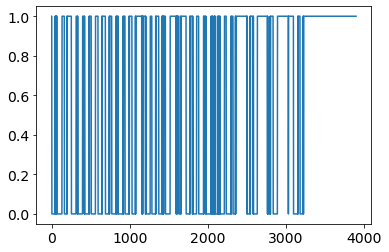

In [103]:
# Evaluate on the val set
with torch.no_grad():
    val_outputs = model(X_val_tensor, val_lengths_tensor)
    predicted_labels = (torch.sigmoid(val_outputs) > 0.5).float()
    totValWeightAcc = []
    totValAcc = []
    for i, validLen in enumerate(val_lengths_tensor):
        wts = valBinaryYPadded[i][:int(validLen)]*class_weights.numpy()
#         print(np.max(wts))
        wts[wts == 0] = 1
#         print(wts)
#         print(np.max(wts))
#         print(y_val_tensor[i, :int(validLen)].shape)
        wtCorrect = np.sum(np.array(wts*(predicted_labels[i,:int(validLen)].flatten() == y_val_tensor[i, :int(validLen)]).numpy()))
#         print(correct)
#         print(np.sum(np.array(tr_class_weights[i,:int(validLen)])))
        weightedAcc = wtCorrect/np.sum(np.array(wts))
        acc = np.sum((predicted_labels[i,:int(validLen)].flatten() == y_val_tensor[i, :int(validLen)]).numpy())/validLen
#         accuracy = torch.sum(predicted_labels == y_val_tensor[:validLen] / len(validLen))
        totValAcc.append(acc)
        totValWeightAcc.append(weightedAcc)
    avgValAcc = np.mean(totValAcc)
    avgValWtAcc = np.mean(totValWeightAcc)
    print(f'Val Accuracy: {avgValAcc}',)
    print(f'Val Weighted Accuracy: {avgValWtAcc}')
    plt.plot(np.arange(1,len(predicted_labels[0])+1),predicted_labels[0])

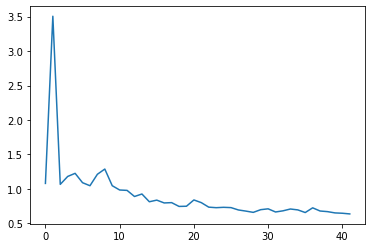

In [77]:
# print(np.max(predicted_labels.numpy()))
# class_weights
old = binTrainLosses
plt.plot(np.arange(0,len(binTrainLosses)),binTrainLosses)

## Create Y-data set for binary sleep state

In [40]:

# f1s=[0.4044,0.3952,,0.2634,0.2748,0.274,0.2752,0.2755,0.2793,0.2782,0.2788,0.281,0.2781,0.2769,0.2753,0.2769,0.278,0.2821,0.2866,0.2885,0.2915,0.2889,0.291,0.2913,0.2935,0.2946,0.2957,0.2963,0.2985,0.3003,0.3021,0.304,0.3049,0.3068,0.3074,0.3077,0.309,0.3105,0.3118,0.3133,0.3129,0.3144,0.315,0.3151,0.3168,0.3181,0.3193,0.3205,0.3214,0.3224,0.324,0.3267,0.3297,0.3319,0.3355,0.3387,0.3417,0.3442,0.3462,0.3484,0.3513,0.353,0.3554,0.3587,0.3608,0.3629,0.3634,0.3655,0.3681,0.3694,0.3724,0.3744,0.3776,0.3784,0.3796,0.3818,,0.3835,0.385,0.3867,0.3871,0.3892,0.3919,0.3933,0.3945,0.3957,0.3964,0.3984,0.3997,0.4013,0.4021,0.4037,0.4047,0.4056,0.4065,0.4081,0.4098,0.4109,0.4118,0.4127,0.4138,0.4153,0.4164,0.4164,0.4173,0.4186,0.4199,0.4212,0.4224,0.4232,0.4242,0.4243,0.4253,0.4263,0.4264,0.4275,0.4283,0.4294,0.4302,0.4311,0.432,0.4331,0.4341,0.4348,0.4348,0.4351,0.436,0.4371,0.4382,0.4387,0.4392,0.4405,0.4412,0.441,0.4417,0.4427,0.4435,0.4438,0.4445,0.4453,0.4453,0.4459,0.4464,0.4474,0.4477,0.4485,0.4489,0.4497,0.4497,,0.4506,0.4511,0.451,0.4508,0.4517,0.4529,0.4532,0.4535,0.4539,0.455,0.4558,0.456,0.4561,0.4564,0.4567,0.4571,0.4576,0.4581,0.4585,0.459,0.4594,0.4596,0.46,0.4602,0.4609,0.4613,0.4613,0.4621]

In [62]:
np.save('lossScheduler09.npy', binTrainLosses)
np.save('accuraciesScheduler09.npy', binTrainAcc)
np.save('wtedAccuraciesScheduler09.npy', binTrainWtAcc)
np.save('f1sScheduler09.npy', actualf1s)
np.save('valAccScheduler09.npy', valAccAll)
np.save('valWtAccScheduler09.npy', valWtAccAll)

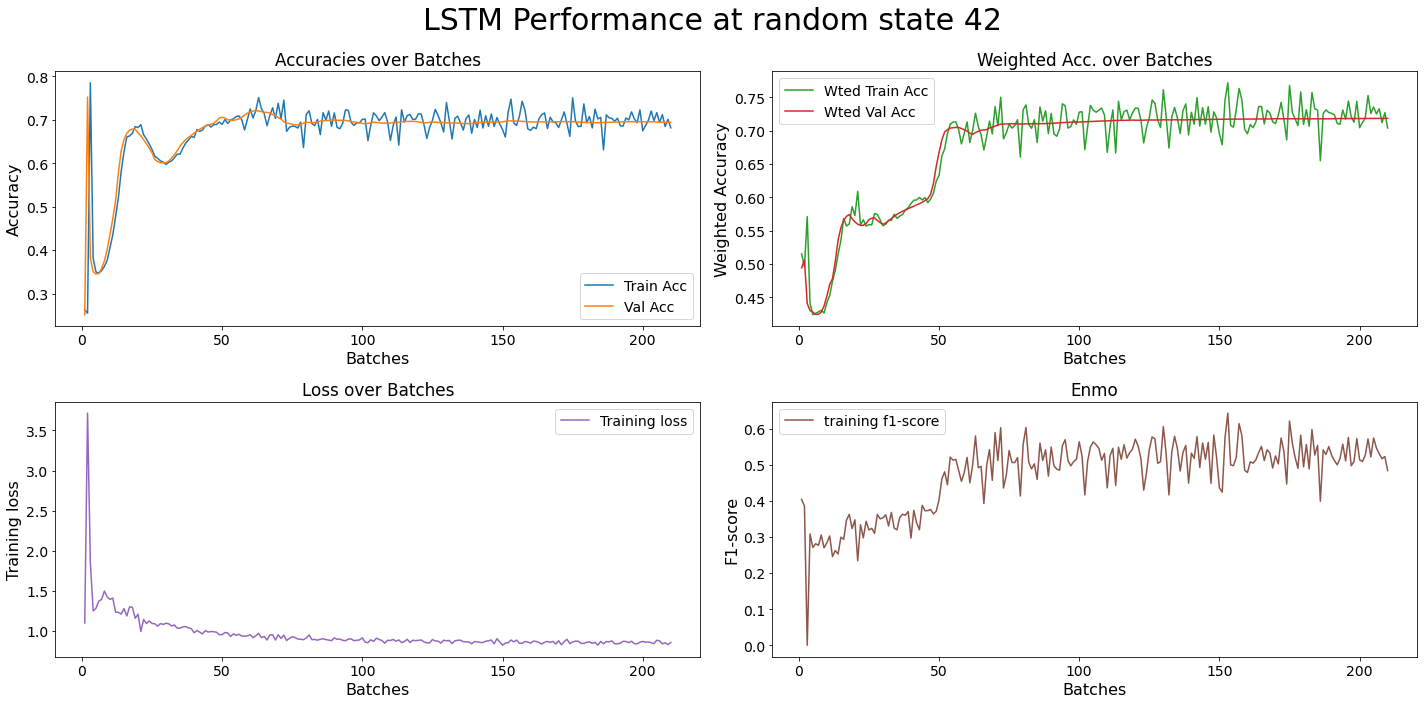

In [96]:
colors = plt.cm.tab10.colors
batchPoints = np.arange(1,len(binTrainLosses)+1)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('LSTM Performance at random state 42',fontsize=30)
plt.rcParams.update({'font.size': 14})

ax[0,0].plot(batchPoints, binTrainAcc,color=colors[0], label='Train Acc')
ax[0,0].plot(batchPoints, valAccAll,color=colors[1], label='Val Acc')
ax[0,0].legend()

ax[0,1].plot(batchPoints, binTrainWtAcc, color=colors[2], label='Wted Train Acc')
ax[0,1].plot(batchPoints, valWtAccAll, color=colors[3], label='Wted Val Acc')
ax[0,1].legend()

ax[1,0].plot(batchPoints, binTrainLosses, color=colors[4], label='Training loss')
ax[1,0].legend()

# plt.show()
ax[1,1].plot(batchPoints, actualf1s, color=colors[5], label='training f1-score')
ax[1,1].legend()

#color linestyle label

ax[0, 0].set_title('Accuracies over Batches')
ax[0, 0].set_xlabel('Batches',fontsize=16)
ax[0, 0].set_ylabel('Accuracy',fontsize=16)

ax[0, 1].set_title('Weighted Acc. over Batches')
ax[0, 1].set_xlabel('Batches',fontsize=16)
ax[0, 1].set_ylabel('Weighted Accuracy',fontsize=16)

ax[1, 0].set_title('Loss over Batches')
ax[1, 0].set_xlabel('Batches',fontsize=16)
ax[1, 0].set_ylabel('Training loss',fontsize=16)

ax[1, 1].set_title('Enmo')
ax[1, 1].set_xlabel('Batches',fontsize=16)
ax[1, 1].set_ylabel('F1-score',fontsize=16)

plt.tight_layout()
plt.show()


## Model for direct detection of state changes

In [ ]:
# Convert to PyTorch tensors

X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

y_train_tensor = torch.FloatTensor(Y_train_intlabels)
y_val_tensor = torch.FloatTensor(Y_val_intlabels)

train_lengths_tensor = torch.FloatTensor(train_lengths)
val_lengths_tensor = torch.FloatTensor(val_lengths)

class_weights = torch.tensor(eventWeights)
tr_class_weights = torch.tensor(np.tile(eventWeights, (y_train_tensor.shape[0],1)))
classTrainLoss = []

# # Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x, lengths):
        # Pack padded sequence
#         print(x.data.shape)
#         print(lengths.data.shape)
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
#         print(x_packed.data.shape)
        # LSTM layer
        out_packed, _ = self.lstm(x_packed)
        # Unpack padded sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        # Fully connected layer
        out = self.fc(out)
        return out
        

# # Initialize the model, loss function, and optimizer
input_size = 2 #X_train_tensor.shape[1]
print('input size: ',input_size)
hidden_size = 128
output_size = 3  # Number of classes
model = LSTMModel(input_size, hidden_size, output_size)
print('class weights shape: ', class_weights.shape)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# # Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, train_lengths_tensor, tr_class_weights)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Training loop
num_epochs = 3
total_step = len(train_loader)
for epoch in range(num_epochs):
    for loadStep, (inputs, labels, lengths, w) in enumerate(train_loader):
#         print(inputs.shape)
#         print(lengths.shape)
#         print(labels.shape)
#         actual_lengths = [min(int(length), maxLen//100) for length in lengths]
#         print(lengths.numpy())
#         print(actual_lengths)
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
#         unpackedLabels = torch.cat([tensor[:int(length)] for tensor, length in zip(labels, lengths)], dim=1)
        unpackedLabels = []
        labelvalues = labels.numpy()
#         print("label shape: ", labels.shape)
        for i, label in enumerate(labelvalues):
            unpackedLabels.append(label[:int(lengths[i])])
#         unpackedLabels = torch.cat([tensor[:length] for tensor, length in zip(labels, lengths)], dim=0)
#         unpackedLabels = np.array(unpackedLabels)
#         print('outputs shape: ', outputs.shape)
#         print('labels shape: ', unpackedLabels.shape)
        loss = 0.0

        for i in range(outputs.size(0)): #for each sequence in batch
#             print('lengths: ', )
#             print(outputs[i].shape)
#             print(labels[i][:int(lengths[i])].shape)
            outputstrun = outputs[i,:int(lengths[i]),:]
            labelstrun = labels[i,:int(lengths[i])].long()
#             print(outputstrun.shape)
#             print(labelstrun.shape)
#             print('computing losses...')
            outputstrun = outputstrun.double()
            labelstrun = labelstrun.long()
            loss += criterion(outputstrun, labelstrun)
#         print('loss computed')
        # Normalize the loss by number of total outputs
        loss /= outputs.size(0)
        loss.backward()
        optimizer.step()
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loadStep+1, total_step, loss.item()))
        classTrainLoss.append(loss.item())
    scheduler.step()

In [ ]:
# Evaluate on the val set
with torch.no_grad():
    val_outputs = model(X_val_tensor, val_lengths_tensor)
    predicted_labels = torch.argmax(val_outputs, dim=2)
    totWeightAcc = []
    for i, validLen in enumerate(val_lengths_tensor):
#         print(validLen)
#         weights = 
#         print(tr_class_weights[i,:int(validLen)].shape)
#         print(predicted_labels[i].shape)
#         print(y_val_tensor[i, :int(validLen)].shape)
#         print(predicted_labels[i])
#         print(y_val_tensor[i, :int(validLen)])
#         print((predicted_labels[i] == y_val_tensor[i, :int(validLen)]))
        correct = np.sum(np.array(tr_class_weights[i,:int(validLen)]*(predicted_labels[i,:int(validLen)] == y_val_tensor[i, :int(validLen)])))
#         print(correct)
#         print(np.sum(np.array(tr_class_weights[i,:int(validLen)])))
        weightedAcc = correct/np.sum(np.array(tr_class_weights[i,:int(validLen)]))
#         accuracy = torch.sum(predicted_labels == y_val_tensor[:validLen] / len(validLen))
        totWeightAcc.append(weightedAcc)
    avgAcc = np.mean(totWeightAcc)
    print(f'Val Accuracy:',(predicted_labels[i,:int(validLen)] == y_val_tensor[i, :int(validLen)])/validLen)
    print(f'Val Weighted Accuracy: {avgAcc}')
    